In [1]:
!pip install ydf koolbox scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Imports and configs

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from xgboost import XGBRegressor
from koolbox import Trainer
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import json
import ydf

ydf.verbose(2)
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"

    metric = root_mean_squared_log_error
    target = "Calories"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

# Training base models

In [5]:
histgb_params = {
    "l2_regularization": 83.89023753261954,
    "learning_rate": 0.014076263018504506,
    "max_depth": 167,
    "max_features": 0.35671906170746404,
    "max_iter": 2175,
    "max_leaf_nodes": 441,
    "min_samples_leaf": 41,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5099047573235393,
    "learning_rate": 0.04655222942419148,
    "min_child_samples": 39,
    "min_child_weight": 0.5763597850247795,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 94,
    "random_state": 42,
    "reg_alpha": 13.37124947203867,
    "reg_lambda": 3.4607082189282656,
    "subsample": 0.8594971769419172,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.44242724444333914,
    "learning_rate": 0.02648790357768195,
    "min_child_samples": 31,
    "min_child_weight": 0.565923097348698,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 91,
    "random_state": 42,
    "reg_alpha": 14.802741846604295,
    "reg_lambda": 3.285199583781151,
    "subsample": 0.4765616561570595,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.562776356802306,
    "colsample_bynode": 0.9612908685331664,
    "colsample_bytree": 0.6576899092549643,
    "early_stopping_rounds": 100,
    "eval_metric": "rmse",
    "gamma": 6.906307575453604,
    "learning_rate": 0.035818175355750034,
    "max_depth": 79,
    "max_leaves": 94,
    "min_child_weight": 54,
    "n_estimators": 10000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 40.48896149819585,
    "reg_lambda": 50.48291846164928,
    "subsample": 0.987369044259711,
    "verbosity": 0
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [6]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [7]:
histgb_trainer = Trainer(
    HistGradientBoostingRegressor(**histgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

histgb_trainer.fit(X, y)

scores["HistGB"] = histgb_trainer.fold_scores
oof_preds["HistGB"] = histgb_trainer.oof_preds
test_preds["HistGB"] = histgb_trainer.predict(X_test)

Training HistGradientBoostingRegressor

--- Fold 0 - root_mean_squared_log_error: 0.0610 - Time: 125.10 s
--- Fold 1 - root_mean_squared_log_error: 0.0616 - Time: 107.74 s
--- Fold 2 - root_mean_squared_log_error: 0.0608 - Time: 140.76 s
--- Fold 3 - root_mean_squared_log_error: 0.0621 - Time: 112.21 s
--- Fold 4 - root_mean_squared_log_error: 0.0608 - Time: 128.05 s

------ Overall root_mean_squared_log_error: 0.0612 - Mean root_mean_squared_log_error: 0.0612 ± 0.0005 - Time: 614.80 s


## LightGBM (gbdt)

In [8]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_trainer.fit(X, y, fit_args)

scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.58626	valid_0's l2: 12.8612
[1000]	valid_0's rmse: 3.57258	valid_0's l2: 12.7633
Early stopping, best iteration is:
[1164]	valid_0's rmse: 3.57037	valid_0's l2: 12.7476
--- Fold 0 - root_mean_squared_log_error: 0.0618 - Time: 35.39 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.64538	valid_0's l2: 13.2888
[1000]	valid_0's rmse: 3.62694	valid_0's l2: 13.1547
[1500]	valid_0's rmse: 3.62361	valid_0's l2: 13.1306
Early stopping, best iteration is:
[1425]	valid_0's rmse: 3.62325	valid_0's l2: 13.1279
--- Fold 1 - root_mean_squared_log_error: 0.0622 - Time: 40.55 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.58853	valid_0's l2: 12.8776
[1000]	valid_0's rmse: 3.57473	valid_0's l2: 12.7787
Early stopping, best iteration is:
[1128]	valid_0's rmse: 3.5741	valid_0's l2: 12.7742
--- Fold 2 - root_mean_squa

## LightGBM (goss)

In [9]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_goss_trainer.fit(X, y, fit_args)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.88379	valid_0's l2: 15.0838
[1000]	valid_0's rmse: 3.65662	valid_0's l2: 13.3709
[1500]	valid_0's rmse: 3.6177	valid_0's l2: 13.0878
[2000]	valid_0's rmse: 3.60195	valid_0's l2: 12.9741
[2500]	valid_0's rmse: 3.59361	valid_0's l2: 12.914
[3000]	valid_0's rmse: 3.58981	valid_0's l2: 12.8867
[3500]	valid_0's rmse: 3.58735	valid_0's l2: 12.8691
Early stopping, best iteration is:
[3546]	valid_0's rmse: 3.58712	valid_0's l2: 12.8675
--- Fold 0 - root_mean_squared_log_error: 0.0653 - Time: 188.28 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 3.96722	valid_0's l2: 15.7388
[1000]	valid_0's rmse: 3.71884	valid_0's l2: 13.8298
[1500]	valid_0's rmse: 3.6756	valid_0's l2: 13.5101
[2000]	valid_0's rmse: 3.65979	valid_0's l2: 13.3941
[2500]	valid_0's rmse: 3.65127	valid_0's l2: 13.3317
[3000]	valid_0's rmse: 3.64734	valid_0's l2: 13.3031
Early stoppin

## XGBoost

In [10]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 500
}

xgb_trainer.fit(X, y, fit_args)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

[0]	validation_0-rmse:60.21653
[500]	validation_0-rmse:4.01644
[1000]	validation_0-rmse:3.71865
[1500]	validation_0-rmse:3.65990
[2000]	validation_0-rmse:3.64129
[2500]	validation_0-rmse:3.63325
[3000]	validation_0-rmse:3.62950
[3500]	validation_0-rmse:3.62516
[4000]	validation_0-rmse:3.62282
[4500]	validation_0-rmse:3.62130
[4534]	validation_0-rmse:3.62128
--- Fold 0 - root_mean_squared_log_error: 0.0645 - Time: 147.76 s

[0]	validation_0-rmse:60.39554
[500]	validation_0-rmse:4.04390
[1000]	validation_0-rmse:3.78810
[1500]	validation_0-rmse:3.73211
[2000]	validation_0-rmse:3.71423
[2500]	validation_0-rmse:3.70553
[3000]	validation_0-rmse:3.70084
[3500]	validation_0-rmse:3.69861
[4000]	validation_0-rmse:3.69664
[4500]	validation_0-rmse:3.69549
[5000]	validation_0-rmse:3.69510
[5500]	validation_0-rmse:3.69449
[5912]	validation_0-rmse:3.69439
--- Fold 1 - root_mean_squared_log_error: 0.0661 - Time: 174.09 s

[0]	validation_0-rmse:60.48680
[500]	validation_0-rmse:4.

## Yggdrasil

In [11]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [12]:
ydf_trainer = Trainer(
    YDFRegressor(GradientBoostedTreesLearner)(ydf_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

ydf_trainer.fit(X, y)

scores["Yggdrasil"] = ydf_trainer.fold_scores
oof_preds["Yggdrasil"] = ydf_trainer.oof_preds
test_preds["Yggdrasil"] = ydf_trainer.predict(X_test)

Training YDFXRegressor

--- Fold 0 - root_mean_squared_log_error: 0.0621 - Time: 113.65 s
--- Fold 1 - root_mean_squared_log_error: 0.0619 - Time: 162.44 s
--- Fold 2 - root_mean_squared_log_error: 0.0621 - Time: 86.33 s
--- Fold 3 - root_mean_squared_log_error: 0.0637 - Time: 206.78 s
--- Fold 4 - root_mean_squared_log_error: 0.0626 - Time: 107.62 s

------ Overall root_mean_squared_log_error: 0.0625 - Mean root_mean_squared_log_error: 0.0625 ± 0.0006 - Time: 677.81 s


# Ensembling with Ridge

In [13]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [14]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [15]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 1),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(
        Ridge(**params),
        cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
        metric=CFG.metric,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return trainer.overall_score

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-01 06:40:36,699] A new study created in memory with name: no-name-871d6575-6a3b-400f-a6c0-4c7d6235db0b
[I 2025-05-01 06:40:41,307] Trial 3 finished with value: 0.060828270912063775 and parameters: {'alpha': 0.6833335551220318, 'tol': 0.002383907014867397}. Best is trial 3 with value: 0.060828270912063775.
[I 2025-05-01 06:40:41,391] Trial 2 finished with value: 0.060828270769930824 and parameters: {'alpha': 0.5683552034140139, 'tol': 0.006716433891988368}. Best is trial 2 with value: 0.060828270769930824.
[I 2025-05-01 06:40:41,854] Trial 0 finished with value: 0.0608282706144256 and parameters: {'alpha': 0.44255919984518544, 'tol': 0.001257458363092353}. Best is trial 0 with value: 0.0608282706144256.
[I 2025-05-01 06:40:41,901] Trial 1 finished with value: 0.06082827051833635 and parameters: {'alpha': 0.36482705482250344, 'tol': 0.0066218503580291535}. Best is trial 1 with value: 0.06082827051833635.
[I 2025-05-01 06:40:45,893] Trial 4 finished with value: 0.06082827074101

In [16]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 0.00024106534337479642,
  "tol": 0.009887229920774652
}


In [17]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

ridge_trainer.fit(X, y)

scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
ridge_test_preds = ridge_trainer.predict(X_test)

Training Ridge

--- Fold 0 - root_mean_squared_log_error: 0.0605 - Time: 0.12 s
--- Fold 1 - root_mean_squared_log_error: 0.0610 - Time: 0.10 s
--- Fold 2 - root_mean_squared_log_error: 0.0604 - Time: 0.11 s
--- Fold 3 - root_mean_squared_log_error: 0.0616 - Time: 0.11 s
--- Fold 4 - root_mean_squared_log_error: 0.0606 - Time: 0.10 s

------ Overall root_mean_squared_log_error: 0.0608 - Mean root_mean_squared_log_error: 0.0608 ± 0.0004 - Time: 1.47 s


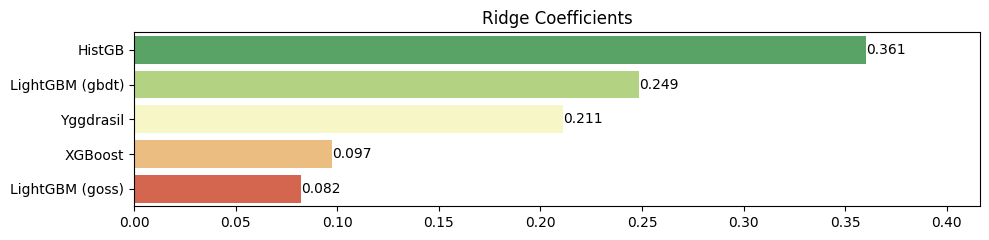

In [18]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [19]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.062124
1,750001,108.138684
2,750002,87.352407
3,750003,125.973259
4,750004,76.032809


# Results

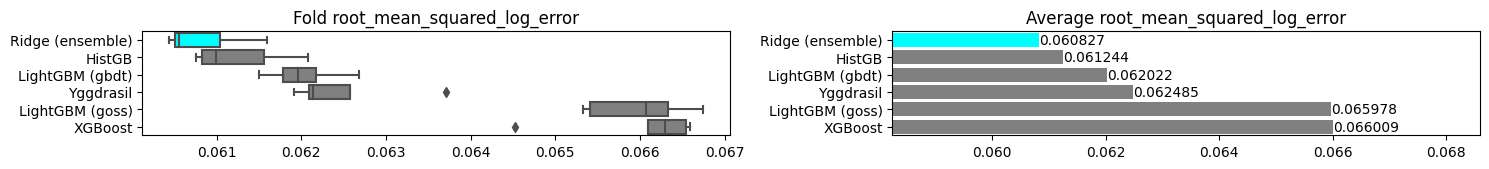

In [20]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric.__name__}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric.__name__}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()